In [2]:
#first I have downloaded the GLD and USO daily prices form yahoo finance, and saved them as csv files
#we will go through all the steps to create a simple pair trading strategy between them.
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen as johansen_test
from statsmodels.tsa.stattools import coint as cadf_test
import datetime
from statsmodels.regression.linear_model import OLS as least_sqaures_regression
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.regression.rolling import RollingOLS

ewc = pd.read_csv("../EWC_vs_EWA_mean_reversion_bollinger_band/Stock_data/EWC.csv")
ewa = pd.read_csv("../EWC_vs_EWA_mean_reversion_bollinger_band/Stock_data/EWA.csv")
ewa["Date"] = pd.to_datetime(ewa["Date"])
ewc["Date"] = pd.to_datetime(ewc["Date"])



1.404935009410224
0.7100701951177416


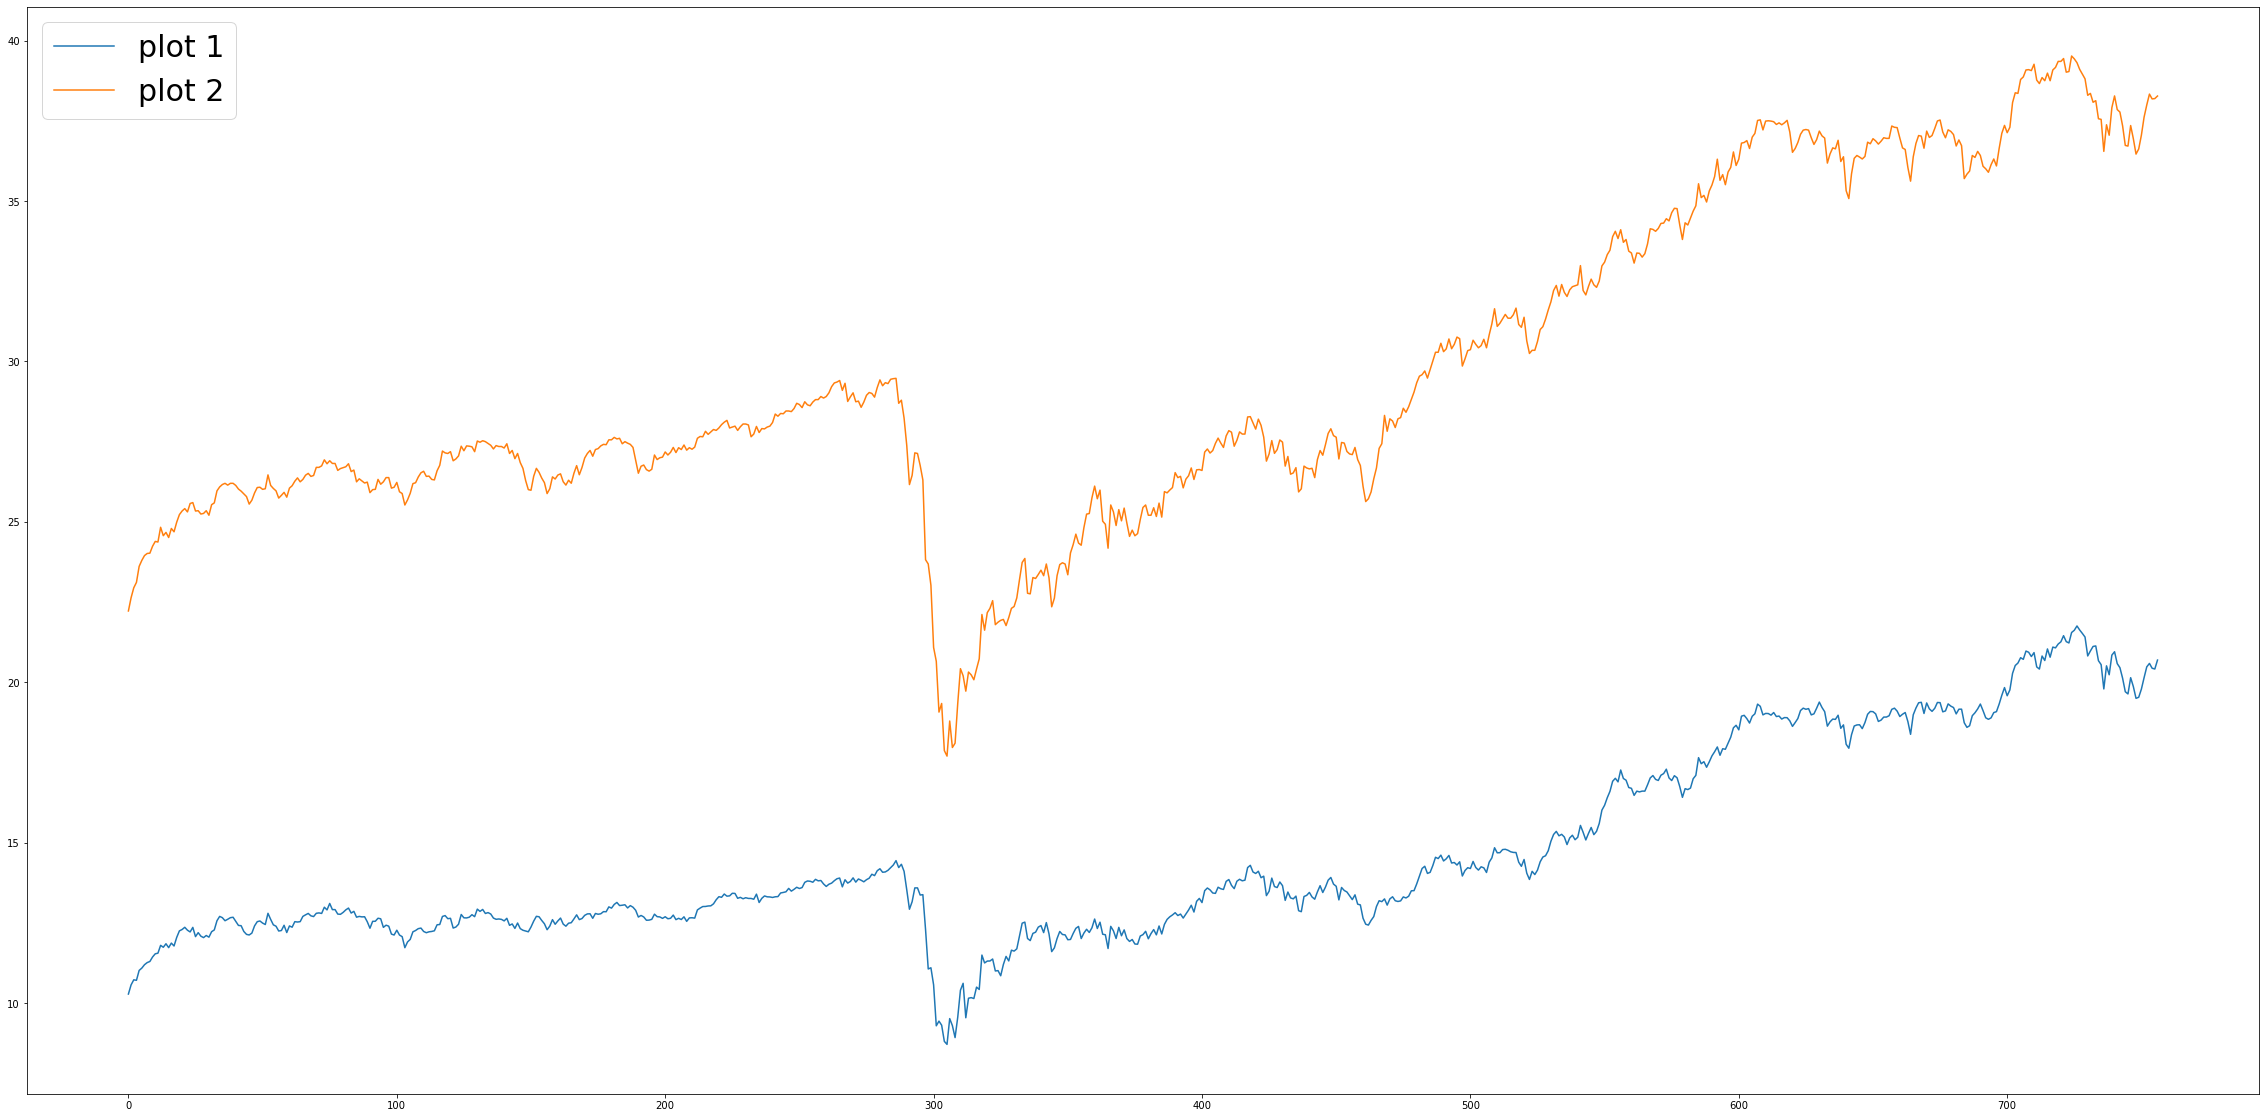

In [17]:
#find the hedge ratio with a simple least sqaures regression
model_1 = least_sqaures_regression(ewc["Open"],ewa["Open"])
model_2 = least_sqaures_regression(ewa["Open"],ewc["Open"]) #switch the dependant and independant variables
results_1 = model_1.fit()
results_2 = model_2.fit()
print(results_1.params[0])
print(results_2.params[0])


stationary_plot = pd.DataFrame()
stationary_plot["Plot"] = ewc["Open"] - results_2.params[0] * ewa["Open"]


plt.figure(figsize=(40,20))
plt.plot(stationary_plot["Plot"] , label = "plot 1")
plt.plot(ewc["Open"] , label = "plot 2")

plt.legend(loc="upper left", prop={'size': 30})
plt.savefig("staionary example", dpi=200,bbox_inches='tight')
plt.show()



In [18]:
adfuller(stationary_plot["Plot"])

(-0.439959559222557,
 0.9032101486279716,
 7,
 749,
 {'1%': -3.439110818166223,
  '5%': -2.8654065210185795,
  '10%': -2.568828945705979},
 -143.3804208871445)

In [19]:
adfuller(ewc["Open"])

(-0.7982895406439698,
 0.8196239858542839,
 7,
 749,
 {'1%': -3.439110818166223,
  '5%': -2.8654065210185795,
  '10%': -2.568828945705979},
 513.3832739948602)

In [82]:
model_1 = least_sqaures_regression(ewc["Open"] , ewa["Open"])
results_1 = model_1.fit()
slope = results_1.params[0]
print("MODEL 1")
print(results_1.params)

rolling_regerssion = RollingOLS(ewc["Open"], ewa["Open"], window=20)
rolling_results = rolling_regerssion.fit()
slope_function_20 = rolling_results.params
slope_function_20 = slope_function_20.rename(columns={"Open" : "Slope"})
slope_function_20

MODEL 1
Open    1.404935
dtype: float64


,Slope
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
752,1.549470
753,1.546499
754,1.543937
755,1.541742


In [54]:
ewc["Open"].min()
ewc["Open"].max()

39.516989200852485

C:\Users\brian\AppData\Local\Temp/ipykernel_27116/495066750.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


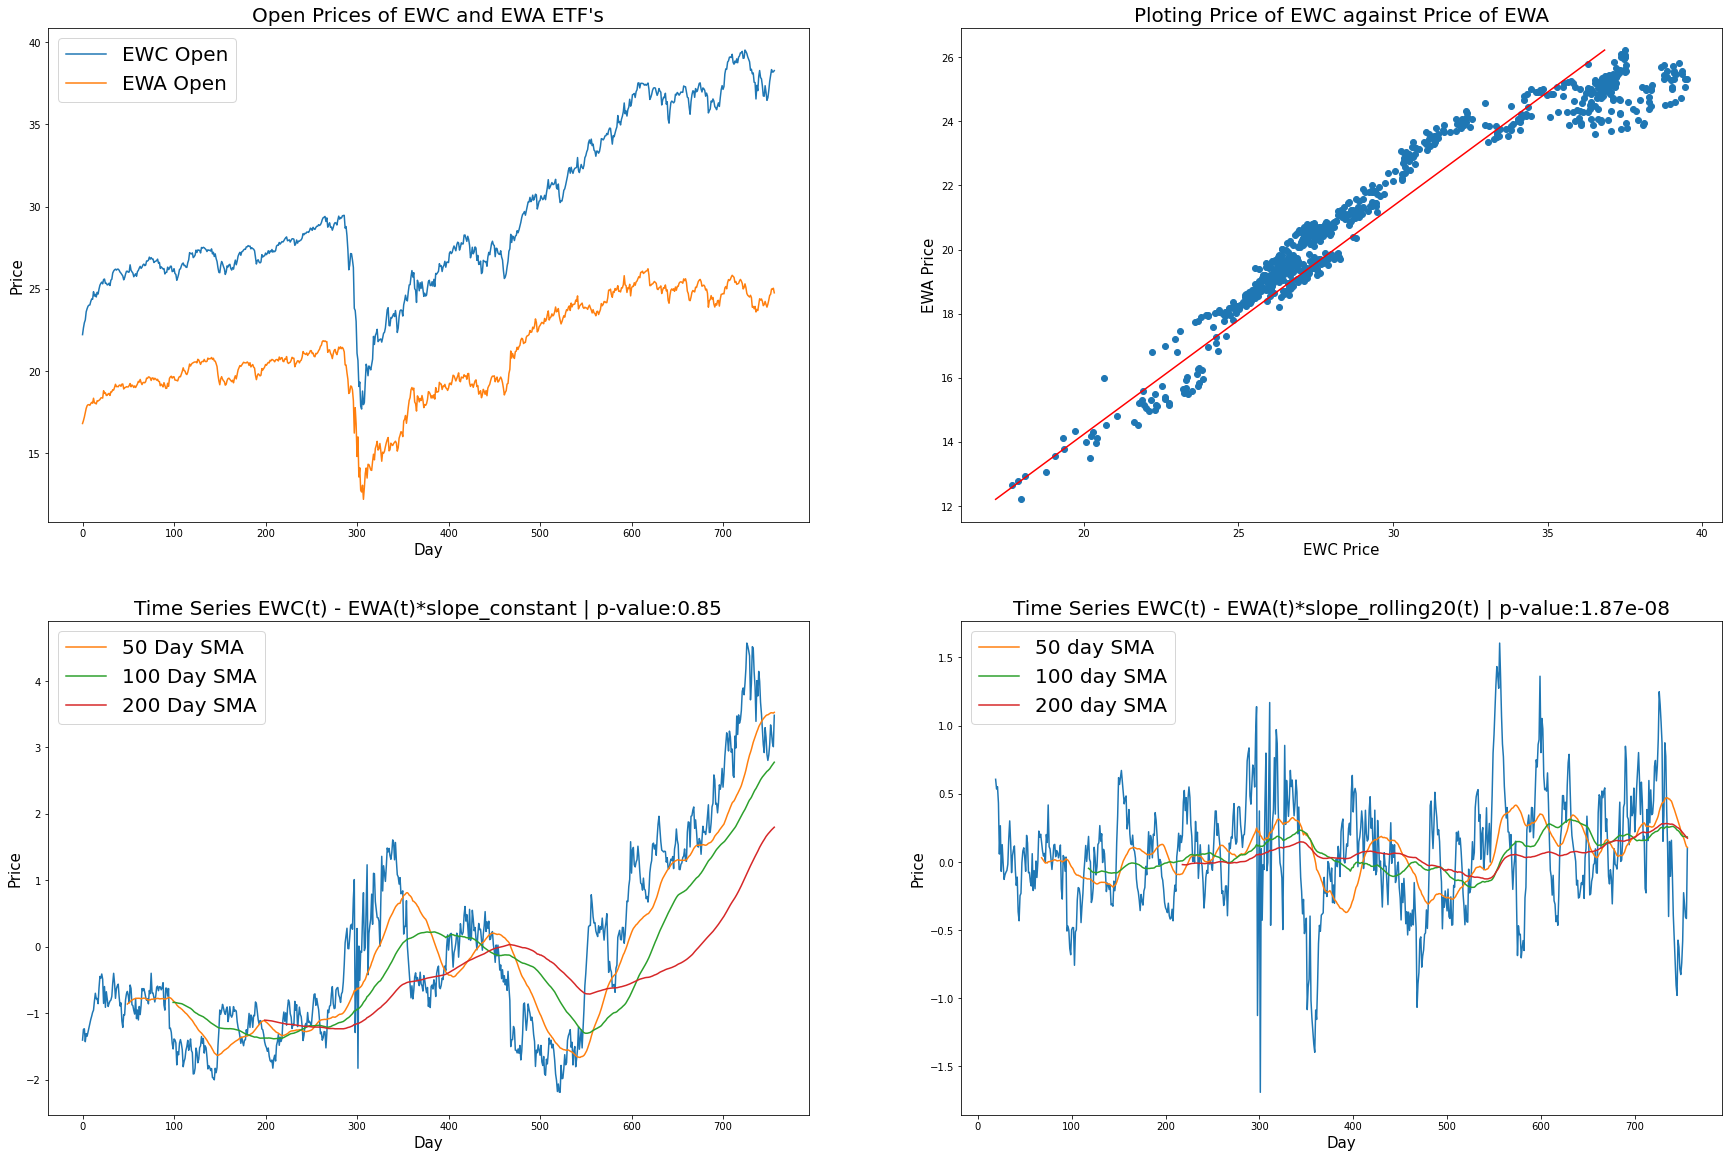

In [115]:

fig, axs = plt.subplots(2,2,figsize=(30,20))

axs[0,0].plot(ewc["Open"],label="EWC Open")
axs[0,0].plot(ewa["Open"], label = "EWA Open")
axs[0,0].legend(loc="upper left", prop={'size': 20})
axs[0,0].set_title("Open Prices of EWC and EWA ETF's", fontsize =20)
axs[0,0].set_xlabel("Day", fontsize=15)
axs[0,0].set_ylabel("Price" , fontsize=15)


axs[0,1].scatter(ewc["Open"], ewa["Open"])
axs[0,1].set_title("Ploting Price of EWC against Price of EWA", fontsize=20)
axs[0,1].set_xlabel("EWC Price", fontsize=15)
axs[0,1].set_ylabel("EWA Price" , fontsize=15)
axs[0,1].plot( [ ewa["Open"].min()*slope , ewa["Open"].max()*slope] , [ewa["Open"].min() , ewa["Open"].max() ], color="red")

linear_reg_plot = pd.DataFrame()
linear_reg_plot["Date"] = ewc["Date"]
linear_reg_plot["Plot"] = ewc["Open"] - ewa["Open"]*slope
linear_reg_plot["Rolling Plot"] = ewc["Open"] - ewa["Open"]*slope_function_20["Slope"]


#calculate p-values
p_value_rolling = adfuller(linear_reg_plot["Rolling Plot"].dropna())[1]
p_value_constant = adfuller(linear_reg_plot["Plot"])[1]


axs[1,0].plot(linear_reg_plot["Plot"])
axs[1,0].plot(linear_reg_plot["Plot"].rolling(window=50).mean(), label = "50 Day SMA")
axs[1,0].plot(linear_reg_plot["Plot"].rolling(window=100).mean(), label="100 Day SMA")
axs[1,0].plot(linear_reg_plot["Plot"].rolling(window=200).mean(), label="200 Day SMA")
axs[1,0].legend(loc="upper left", prop={'size': 20})
axs[1,0].set_xlabel("Day", fontsize=15)
axs[1,0].set_ylabel("Price" , fontsize=15)
axs[1,0].set_title("Time Series EWC(t) - EWA(t)*slope_constant | p-value:" + str(round(p_value_constant,2)) , fontsize=20)

axs[1,1].plot(linear_reg_plot["Rolling Plot"])
axs[1,1].plot(linear_reg_plot["Rolling Plot"].rolling(window=50).mean() , label="50 day SMA")
axs[1,1].plot(linear_reg_plot["Rolling Plot"].rolling(window=100).mean(), label="100 day SMA")
axs[1,1].plot(linear_reg_plot["Rolling Plot"].rolling(window=200).mean(), label="200 day SMA")
axs[1,1].legend(loc="upper left", prop={'size': 20})
axs[1,1].set_xlabel("Day", fontsize=15)
axs[1,1].set_ylabel("Price" , fontsize=15)
axs[1,1].set_title("Time Series EWC(t) - EWA(t)*slope_rolling20(t) | p-value:" +  str(round(p_value_rolling,10)), fontsize=20)

fig.savefig("Linear Regession Hedge Ratio Example", dpi=200,bbox_inches='tight')
fig.show()

In [1]:
fig, axs = plt.subplots(1,2,figsize=(30,20))

axs[0].plot(ewc["Open"],label="EWC Open")
axs[0].plot(ewa["Open"], label = "EWA Open")
axs[0].legend(loc="upper left", prop={'size': 20})
axs[0].set_title("Open Prices of EWC and EWA ETF's", fontsize =20)
axs[0].set_xlabel("Day", fontsize=15)
axs[0].set_ylabel("Price" , fontsize=15)


axs[1].scatter(ewc["Open"], ewa["Open"])
axs[1].set_title("Ploting Price of EWC against Price of EWA", fontsize=20)
axs[1].set_xlabel("EWC Price", fontsize=15)
axs[1].set_ylabel("EWA Price" , fontsize=15)
axs[1].plot( [ ewa["Open"].min()*slope , ewa["Open"].max()*slope] , [ewa["Open"].min() , ewa["Open"].max() ], color="red")

fig.savefig("Linear Regression DEMO", dpi=200,bbox_inches='tight')
fig.show()

NameError: name 'plt' is not defined